# Introduction

In this notebook, we provide an intuitive introduction to the foundations of neural networks.

**Take-aways:**
By the end of this notebook, you will have seen:
- how biological brains inspired the construction of artificial neural networks;
- how multi-layer perceptrons (MLPs) provide the backbone of all modern neural networks;
- and how MLPs can approximate any function (universal function approximation theorem).

In [5]:
from labellines import labelLines
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# 1. The Perceptron

Intuitively, one might expect artificial intelligence (AI) to arise when models of human brains are simulated on a computer. This intuition motivated the development of artificial neural networks, which now are the workhorse behind all modern AI models. In this notebook, we will retrace these early developments of artificial intelligence to better understand why language models, such as GPT3, process language the way they do.

The smallest building block of brains are brain cells, also known as neurons. Neurons by themselves are not more intelligent than any other cells in our bodies. The main difference between neurons and other cells is that all approximately 100 billion of neurons in the human brain communicate and process information in a coordinated way, leading to the emergence of intelligence. A good start for artificial intelligence is therefore to first build a model of a neuron, and then make many of those neurons communicate in the hope to see artificial intelligence to emerge.

In the figure below, we illustrate a human neuron in the left panel. The right panel shows a model of the neuron: an artificial neuron, commonly referred to as *perceptron*. The biological neuron consists of a junction of dendrites with the cell nucleus in the middle, and an axon leading away from the neuron. The one ability of neurons that is widely believed to make the emergence of intelligence possible is their ability to receive electrical signals through the dendrites and forward those signals to other neurons along their axons, when the strength of the electrical signals reaches a minimum threshold. The perceptron emulates this behaviour by receiving $n$ input signals $x_1, \ldots, x_n$ which is processed into one output signal $y$.

<img src="biological-neuron.jpg" width="500" style="display: block; margin: 0 auto" >

More specifically, one of the simplest perceptrons can be defined using a combination of the weighted sum of the input signals, and a step function that only returns a value of $1$ when the weighted sum is greater than zero 

$$
y = f(x, w) = \Theta (w_0\, x_0 + \ldots + w_n\, x_n),
$$
where $\Theta(z) = 1$ for $z>0$ and $\Theta(y) = 0$, otherwise. $\Theta(z)$ is referred to as the activation function of the perceptron.

### Task 1: Implement a simple artificial neuron

To get comfortable with how perceptrons process information, implement the simple model described above by completing the code block below. When you are ready, use the following notebook cell to test your implementation.

In [2]:
def perceptron(x):
    """
    Returns the output of a perceptron with 6 input signals.

    Parameters:
        x (List of length 6) Input signals to the perceptron.
    """
    weights = [0.2, -0.3, 0.9, 0.4, -0.9, -0.5]

    # TODO: Calculate y
    z = np.sum(np.array(weights) * np.array(x))

    # Calculate activation
    if z > 0:
        return 1

    return 0

<span style="color: red;">TOOD:</span> Can you please implement some tests / solutions where the function is checked against the correct outputs? Last time I did this for example by pre-implementing the correct solution in a module, see In [6] in https://github.com/equinor/edc2023-optimising-wind-farms/blob/main/03_wind_farm_model/solution.ipynb.

In [ ]:
# Solution

## 2 From perceptrons to multilayer perceptrons (MLPs)

Without activation functions, single perceptrons are mathematically equivalent to linear regression models that have been in machine for a loooong time

$$
    z = \sum _{j=1}^n w_j x_j.
$$

For just two inputs, this makes it possible to visualise the outputs of perceptrons for different input values using straight lines in a plane, see below. Note that it is convential to consider $x_0$ to be fixed to one, $x_0=1$. This makes translations of the lines in the plane possible. The corresponding weight, $w_0$, is commonly referred to as the bias of the perceptron. 

<img src="linear_classifier.png" width="500" style="display: block; margin: 0 auto">

The interpretation of perceptrons as binary linear regressors, i.e. linear classifiers, makes intuitively how artificial neural networks process information on the smallest level. But one perceptron alone is limited in what it can do and certainly does not achieve artificial "intelligence".

To visualise the limitations of a single perceptron, we attempt a simple 2-dimensional classification task using the perceptron.

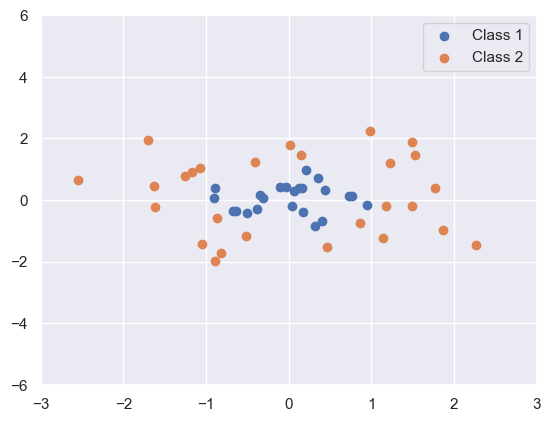

In [4]:
# Generate random data
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1

# Plot the data
plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 1')
plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 2')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.legend()
plt.show()

It is clear that we will not be able to use just a single line to separate the blue dots from the orange dots. But, we could, perhaps, use 4 perceptrons to classify the data...

### Task 2: Find 4 perceptrons that can jointly classify the data points
For example, you could decide that a data point is classified as "blue" if all perceptrons return a 1. Otherwise the data point is classified as orange.

In [34]:
# TODO
perceptron1 = {
    'bias': -2,
    'weight1': 2,
    'weight2': 1
}
perceptron2 = {
    'bias': -2,
    'weight1': -1,
    'weight2': 2
}
perceptron3 = {
    'bias': 2,
    'weight1': 2,
    'weight2': 1
}
perceptron4 = {
    'bias': -3,
    'weight1': 2,
    'weight2': -2
}

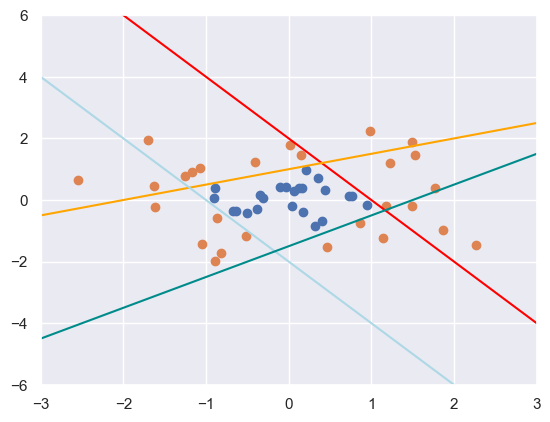

In [35]:
# Plot the data
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

# linear classifications
x1 = np.linspace(-3, 3, 100)
x2 = -(perceptron1['weight1'] * x1 + perceptron1['bias']) / perceptron1['weight2']
plt.plot(x1, x2, linestyle='-', color='red')

x2 = -(perceptron2['weight1'] * x1 + perceptron2['bias']) / perceptron2['weight2']
plt.plot(x1, x2, linestyle='-', color='orange')

x2 = -perceptron3['weight1'] / perceptron3['weight2'] * x1 - perceptron3['bias'] / perceptron3['weight2']
plt.plot(x1, x2, linestyle='-', color='lightblue')

x2 = -perceptron4['weight1'] / perceptron4['weight2'] * x1 - perceptron4['bias'] / perceptron4['weight2']
plt.plot(x1, x2, linestyle='-', color='darkcyan')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.show()

Here if you get an output of 1 from each of these linear classifiers only if the point lies inside the region. If all the perceptrons produce a 1, the output nepceptron and weights will be set can be set such that it produces an output of 1 only in the case when all the inputs to it are 1.

While this is shown in 2D space, it generalises in any number of dimensions.

<img src="complex_classifier_perceptron_diagram.png" width="1000" style="display: block; margin: 0 auto">

A multi-layer perceptron network has the same general structure:

<img src="multi_layer_perceptron_network.avif" width="700" style="display: block; margin: 0 auto">

The above diagram is also known as a **fully-connected network** because every neuron is connected to every other neuron. This does not have to be the case, which we will demonstrate later.

*TODO: change the image to label w_11 etc*

# 3. Activation Function

## 3.1 Step Function

The activation function is the function that takes you from the input to the output. For a Perceptron, it is the step function.

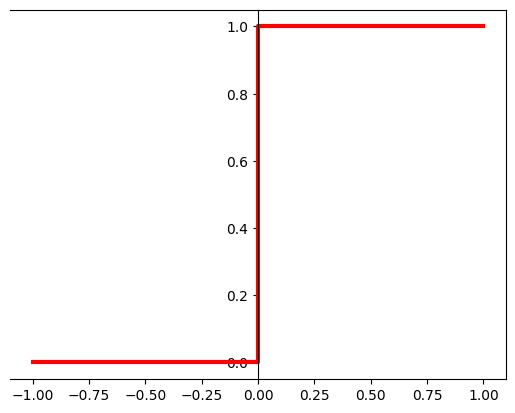

In [4]:
import matplotlib.pyplot as plt

x = [-1, 0, 1]
y = [0, 0, 1]

fig, ax = plt.subplots()
ax.step(x, y, color='red', linewidth=3)

# Move the y-axis ticks to the center
ax.spines['left'].set_position('center')


So far, we have assumed we live in the perfect world where we know all the weights and biases. In reality, we need to find them. 

This is done by randomly assigning weights and biases.
Why?
Because we don't know where else to start.
Then we run the network on each training example, compare the output and the desired output, and adjust the weights to minimise the error.

We want to find the weights and biases of the entire network, i.e. the **parameters of the network**. 
Starting from a random value, we we need to see what the impact of changing a particular parameter is (e.g. $w_{1,1}).
We want a small change in a parameter to lead to a small change in the activation towards the desired activation.

This is where we encounter our first problem with perceptrons: their activation function is a step function.

*TODO: insert diagram with 2 inputs to 1 perceptron, labelled w1, w2, etc*


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def step_function(x):
    return np.where(x > 0, 1, 0)

# Define the function to plot
def plot_sine(delta_z):

    # plot step function
    x = [-0.55, 0, 0.45]
    y = [0, 0, 1]
    plt.step(x, y, color='black', linewidth=3)

    # plot the starting point
    z0 = -0.05
    z = z0 + delta_z
    plt.plot(z0, step_function(z0), 'ro', markerfacecolor='none')
    plt.text(z0, step_function(z0) - 0.2, rf'$z_0 = {z0}$', fontsize=12, ha='center')

    # plot the moving point
    plt.plot(z, step_function(z), 'ro')
    plt.text(z, step_function(z) + 0.2, rf'$z = z_0 + \Delta z = {z:.2f}$', fontsize=12, ha='right')

    plt.ylim(-1, 2)
    plt.xlabel(r'$z = \mathbf{w \cdot x} + b$')
    plt.ylabel(r'$a = f(z)$')
    plt.title(rf'Impact of changing $z$ on activation')
    plt.show()

# Create the slider
slider = FloatSlider(min=-0.15, max=0.5, step=0.01, value=0)

# Create the interactive plot
interact(plot_sine, delta_z=slider)

interactive(children=(FloatSlider(value=0.0, description='delta_z', max=0.5, min=-0.15, step=0.01), Output()),…

<function __main__.plot_sine(delta_z)>

Say we change $w_1$ by $\Delta w_1$, which will change $z$, which will impact $a = f(z)$. 
If we move the slider to the left, $z$ changes (red dot moves left), but the activation $a$ does not change: it was 0 before, but because $z < 0$, it remains unchanged at 0.
If we move the slider slightly to the right, $a$ does not change either.
We changed $w_1$ (and therefore $z$) in both ways and learned nothing about the impact of $w_1$.

If you move the slider further to the right, all of a sudden $z > 0$ and $a = 1$.

With the step function as the activation function, it's difficult to figure out how to adjust the weights and biases to get the desired activation/output.
There is a lack of change or the sudden change in the output with a small change in the parameters.
This is even more the case with a network of perceptrons.

Since the step function is difficult to work with, we want to work with smoother functions, like the sigmoid function.

## 3.2 Sigmoid Function

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the function to plot
def plot_sine(delta_z):

    # plot step function
    x = np.linspace(-20, 20, 100)
    y = sigmoid(x)

    fig, ax = plt.subplots()
    ax.plot(x, y, color='black', linewidth=3)

    # Move the y-axis ticks to the center
    ax.spines['left'].set_position('center')

    # plot the starting point
    z0 = -0.05
    z = z0 + delta_z
    ax.plot(z0, sigmoid(z0), 'ro', markerfacecolor='none')
    ax.text(z0, sigmoid(z0) - 0.2, rf'$z_0 = {z0}$', fontsize=12, ha='center')

    # plot the moving point
    ax.plot(z, sigmoid(z), 'ro')
    ax.text(z, sigmoid(z) + 0.2, rf'$z = z_0 + \Delta z = {z:.2f}$', fontsize=12, ha='right')

    ax.set_ylim([-0.5, 1.5])
    # ax.set_xlim([0, 12])
    # ax.ylim(-1, 2)
    # ax.xlabel(r'$z = \mathbf{w \cdot x} + b$')
    # ax.ylabel(r'$a = f(z)$')
    ax.set_title(rf'Impact of changing $z$ on activation')
    plt.show()

# Create the slider
slider = FloatSlider(min=-7, max=15, step=0.1, value=0)

# Create the interactive plot
interact(plot_sine, delta_z=slider)

interactive(children=(FloatSlider(value=0.0, description='delta_z', max=15.0, min=-7.0), Output()), _dom_class…

<function __main__.plot_sine(delta_z)>

The sigmoid neuron is almost exactly the same as a perceptron, but the activation function is the sigma function $\sigma$.

$$
a = \sigma (z) = \frac{1}{1 + e^{-z}}
$$

Sigma looks like a "blurred" or smoother version of the step function. 
Its behaviour is muh more benign and predictable: when you change $w_1$, you have a measurable change in the output $a$.
The output transitions more smoothly with respect to changes in parameters (weights and biases).

The sigma function is one of many different types of smooth activation functions used in neural networks. Other examples include:

$$
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$
$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$
$$
\text{Swish}(x) = x \cdot \frac{1}{1 + e^{-\beta x}}
$$
$$
\text{ELU}(x) = \begin{cases} x, & \text{if } x > 0 \\ \alpha (e^x - 1), & \text{otherwise} \end{cases}
$$

# 4. Neural Network

Now we have a neural network that uses the sigmoid activation function.
What shall we do with all this power?

## 4.1 MNIST Handwritten Digit Recognition

This is a classic problem for neural networks. 

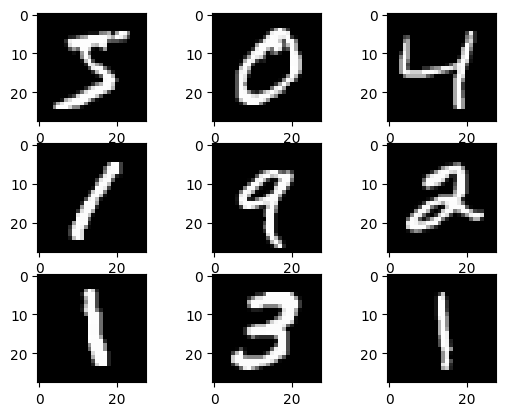

In [7]:
# Plot of images as baseline for comparison
from keras.datasets import mnist
from matplotlib import pyplot
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

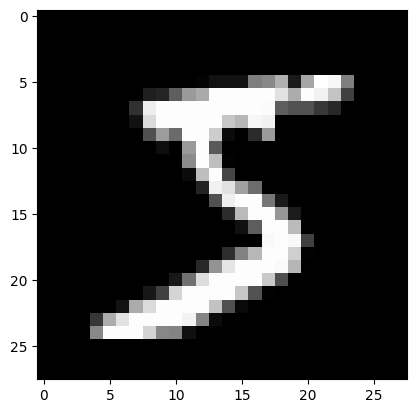

In [8]:
pyplot.imshow(X_train[0], cmap=pyplot.get_cmap('gray'))

Each digit has been binarised and rescaled into an image roughly 20x20 pixels, which is centred in a larger image of 28x28 pixels.

We want to develop a neural network where it takes one of these images as input. The idea is to have the neural network have a high activation/output for the digit that it thinks the input corresponds to, and a low output for all the other digits.

<img src="mnist_digit_recognition_network.png" width="500" style="display: block; margin: 0 auto; background-color: white">

In Section 3, we introduced the idea of finding the parameters of the network by starting with a random set and adjusting them to get to the desired activation.
How do we change the weights and biases in such a way that our activations/outputs end up approaching the desired activations? 
This is the process of training.

The key to any network is lots of training data - the more the better.
The training data in this case is pairs out inputs and outputs, labels by users/experts, which are converted to the desired activation.

<img src="inputs_labels_activations.png" width="500" style="display: block; margin: 0 auto">

1. Initialise the weights and biases of network with random values.
2. Compute network activation (output) for each training image.
This is just a feed forward process: for each image, run it through the network and get an activation and the output.
3. Compute the cost for the entire training data.
By doing this you get an activation for each training image, not the desired activation. We see the activation that this particular instance of the network is going to give you.
Using all these activations, you can compute the cost for the entire training data.
The weaker the performance of the network, the larger the cost.
Lower the cost, better the classification.
We're looking for the ws and bs that give us the minimum cost. We lower the cost, the classification improves and the performance of the network improves.

$$
C_x(\bold{w}, \bold{b}) = \Vert \hat{\underbar{a}}(\underbar{x}) - \underbar{a}(\underbar{x} | \underbar{w}, \underbar{b}) \Vert ^2
$$

$$
C(\bold{w}, \bold{b}) = \frac{1}{n} \sum_{x}C_x(\underbar{w}, \underbar{b})
$$

We average the cost because we don't want the cost to be a function of the number of images in the training data.

4. Update weights and biases using Gradient Descent.
Using the cost, we can adjust the weights and biases of the network using a method called Gradient Descent.
5. Repeat steps 2-4 until the cost reduces to an acceptable network, then you freeze the network.

<img src="training_process.png" width="1000" style="display: block; margin: 0 auto">

# 5. *Bonus:* Gradient Descent and the Backpropagation Algorithm

Step 4 of the training process described above uses Gradient Descent to move the parameters of the network such that the error decreases as training progresses.

If we knew the cost for all possible values of weights and biases, we would end up with a function like this:

<img src="gradient_descent.png" width="500" style="display: block; margin: 0 auto">

Then it would be easy to choose the best parameter values.
Since we don't live in this world, we have to use calculus to determine how to adjust the weights.